In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierBottomUp.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDown.py', '../models/Vanilla.py', '../models/SimplifierTopDownOnlyLast.py'] ['Bottom Up', 'Bottom Up (only last)', 'Top Down', 'Without simplify', 'Top Down (only last)']
(750, 14)
['Bottom Up' 'Bottom Up (only last)' 'Top Down' 'Without simplify'
 'Top Down (only last)']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing']
[10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


In [2]:
all_data = []
for i, row in results_df.iterrows():
    model, dataset, random_state = row.loc[['model', 'dataset', 'random_state']]

    files = glob(f"{results_path}/{dnames_to_ugly[dataset]}/{nice_to_ugly[model]}/"
                f"*{random_state}_evolution.csv")

    for file in files:
        data = pd.read_csv(file)
        
        for gen in gens:
            try:
                row = data[data['gen']==gen].iloc[0] # should have just 1 row
            except Exception as e:
                pass
                # print(e)
                # print(file, gen)
                # print(row)

            all_data.append((model, dataset, *row))
            
all_data_df = pd.DataFrame(all_data, 
                           columns=(
                               'model',
                               'dataset',
                               *row.index
                           ))

all_data_df = all_data_df.replace([np.inf, -np.inf], np.nan).dropna()

print(all_data_df.shape)
print(all_data_df['model'].unique())
print(all_data_df['dataset'].unique())
all_data_df.sample(5)

(7488, 27)
['Bottom Up' 'Bottom Up (only last)' 'Top Down' 'Without simplify'
 'Top Down (only last)']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing']


,model,dataset,gen,evals,best_size,n_simplifications,n_new_hashes,avg train error,avg train size,avg val error,...,std val error,std val size,min train error,min train size,min val error,min val size,max train error,max train size,max val error,max val size
232,Bottom Up,Airfoil,30.0,100.0,16.0,93.0,100.0,44.674403,2.87,46.866649,...,3.790291,2.784439,26.014279,2.0,28.927676,2.0,46.085139,16.0,48.062244,16.0
6501,Bottom Up (only last),Housing,20.0,100.0,8.0,56.0,59.0,84.275277,2.24,82.113035,...,10.899126,1.049952,35.068420,2.0,36.586170,2.0,87.260114,8.0,84.864616,8.0
6887,Top Down,Housing,80.0,100.0,3.0,54.0,51.0,79.266815,2.02,79.586161,...,5.866316,0.140000,35.756210,2.0,38.521950,2.0,80.154786,3.0,80.424206,3.0
6841,Top Down,Housing,20.0,100.0,5.0,37.0,61.0,74.547575,2.04,94.538823,...,8.311982,0.313688,31.543613,2.0,32.370007,2.0,75.368817,5.0,95.723316,5.0
3548,Bottom Up (only last),Energy Cooling,90.0,100.0,19.0,132.0,62.0,77.780213,2.72,80.934737,...,24.075022,2.646054,12.390542,2.0,14.516163,2.0,86.477157,19.0,89.823995,19.0


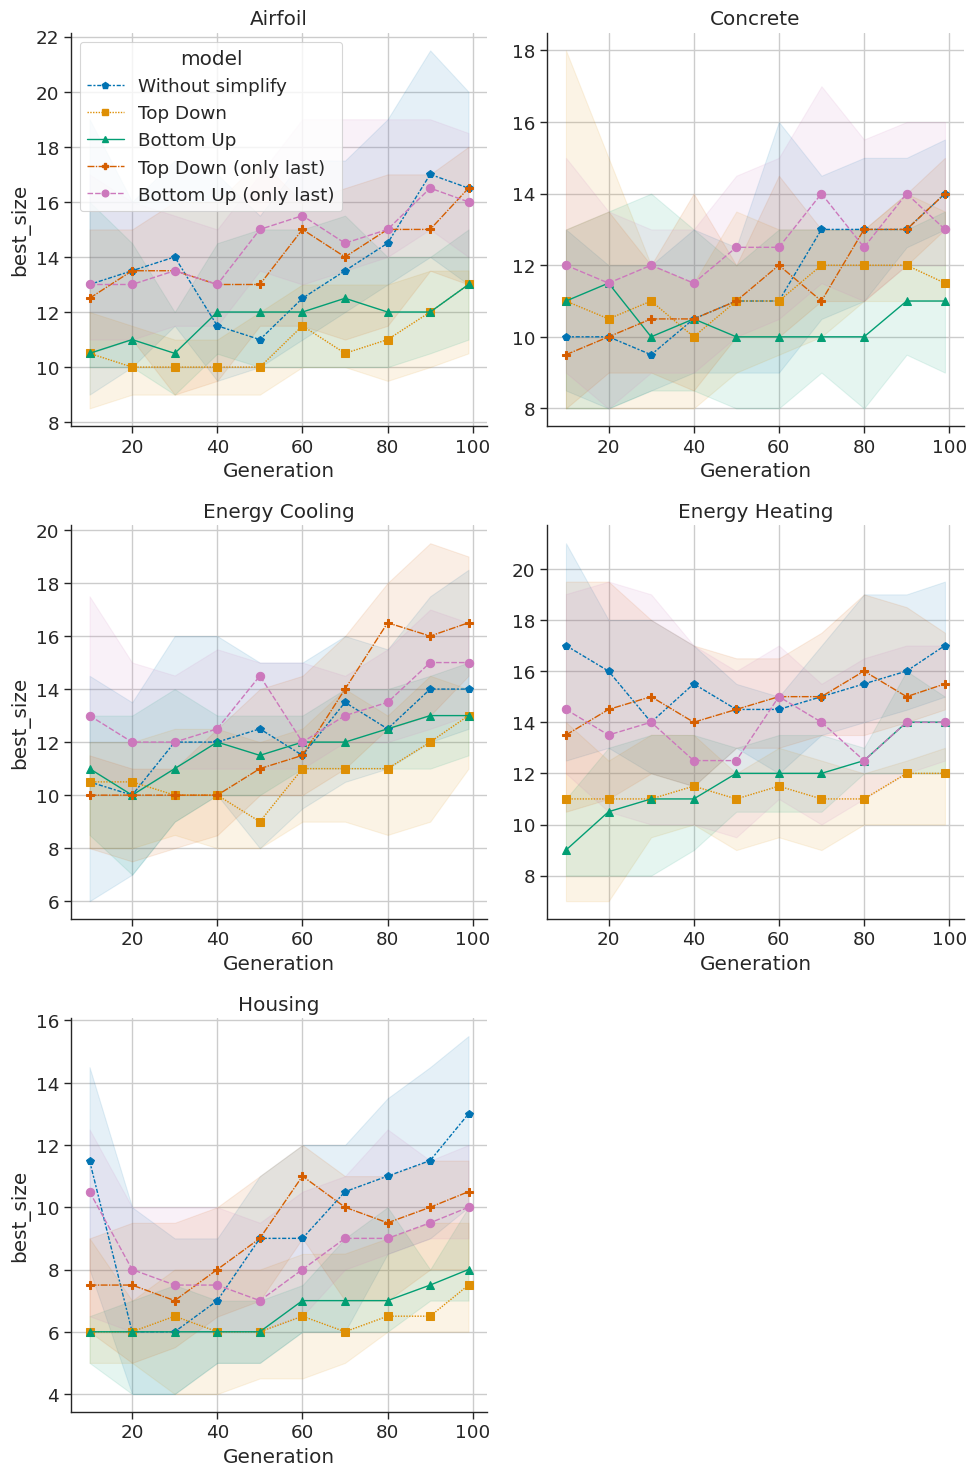

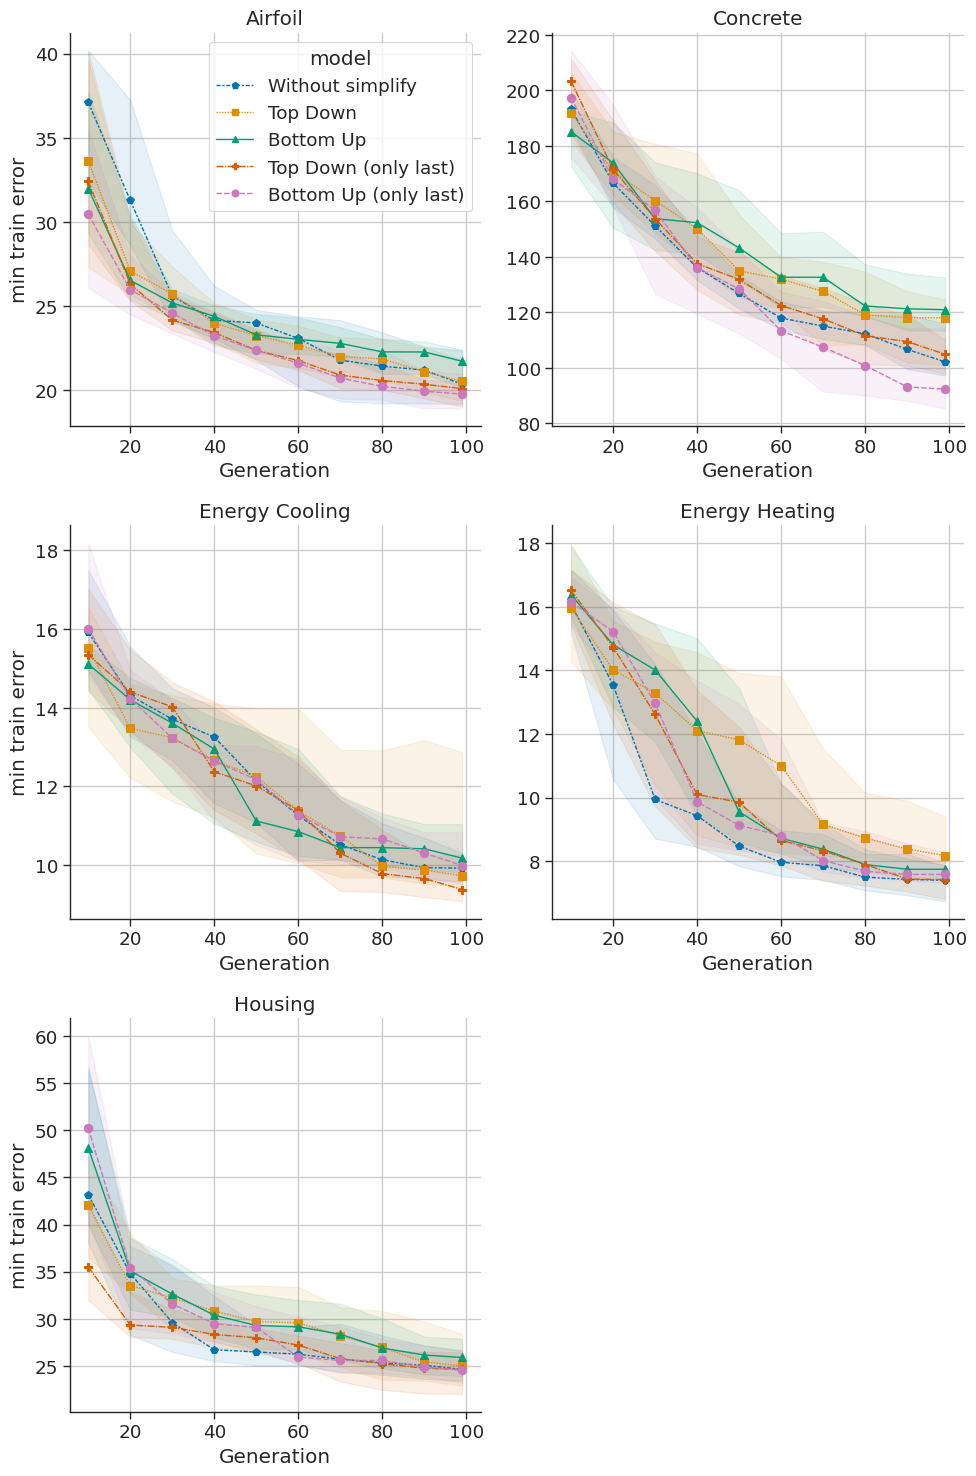

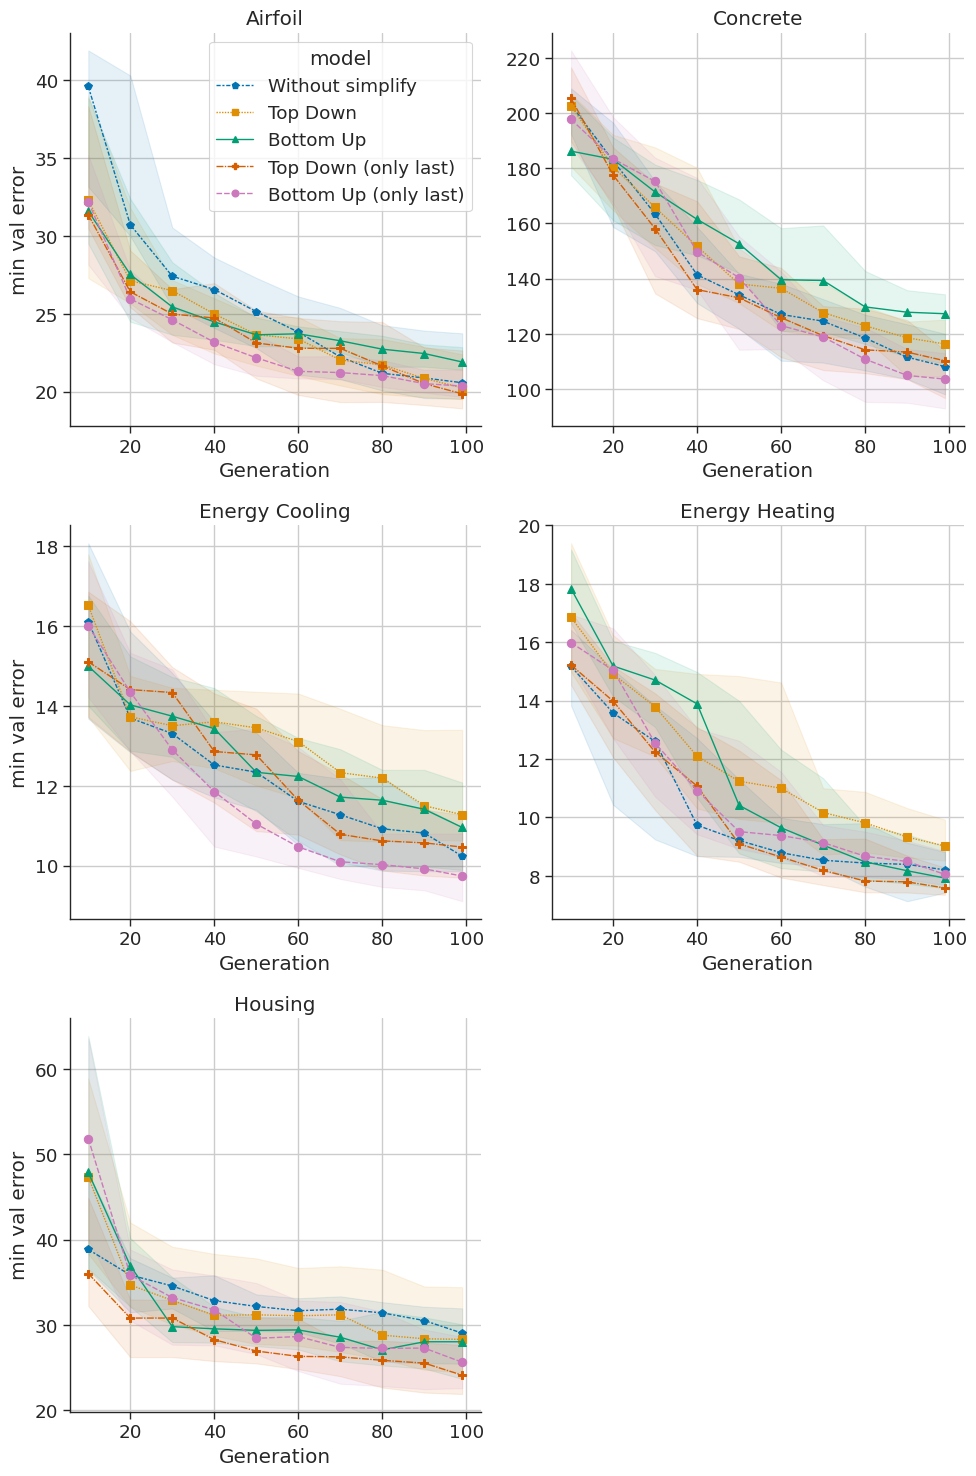

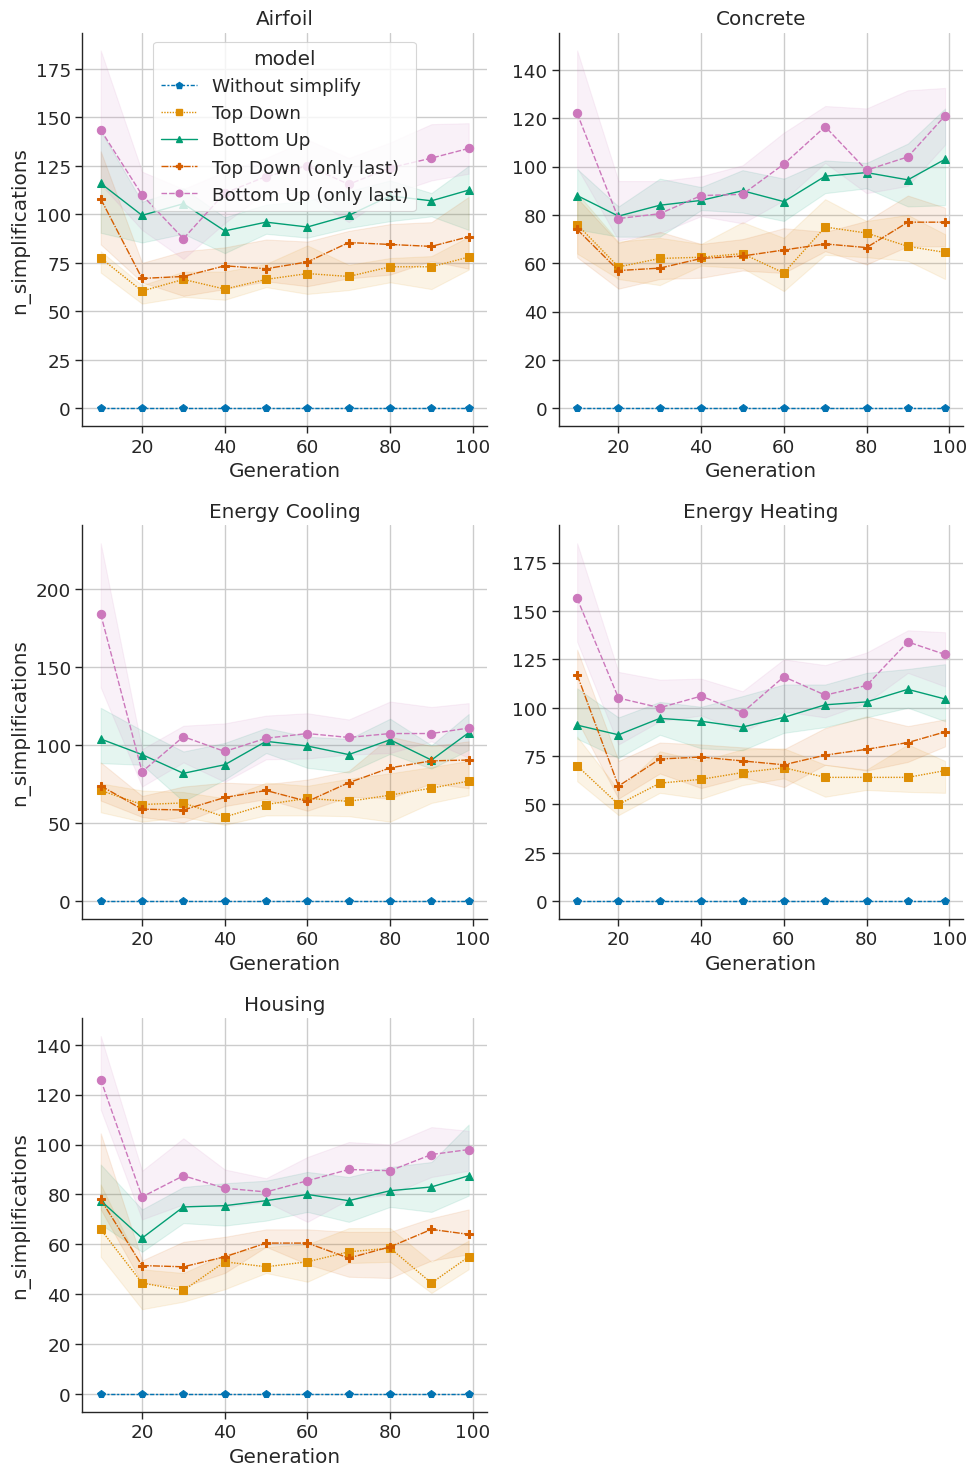

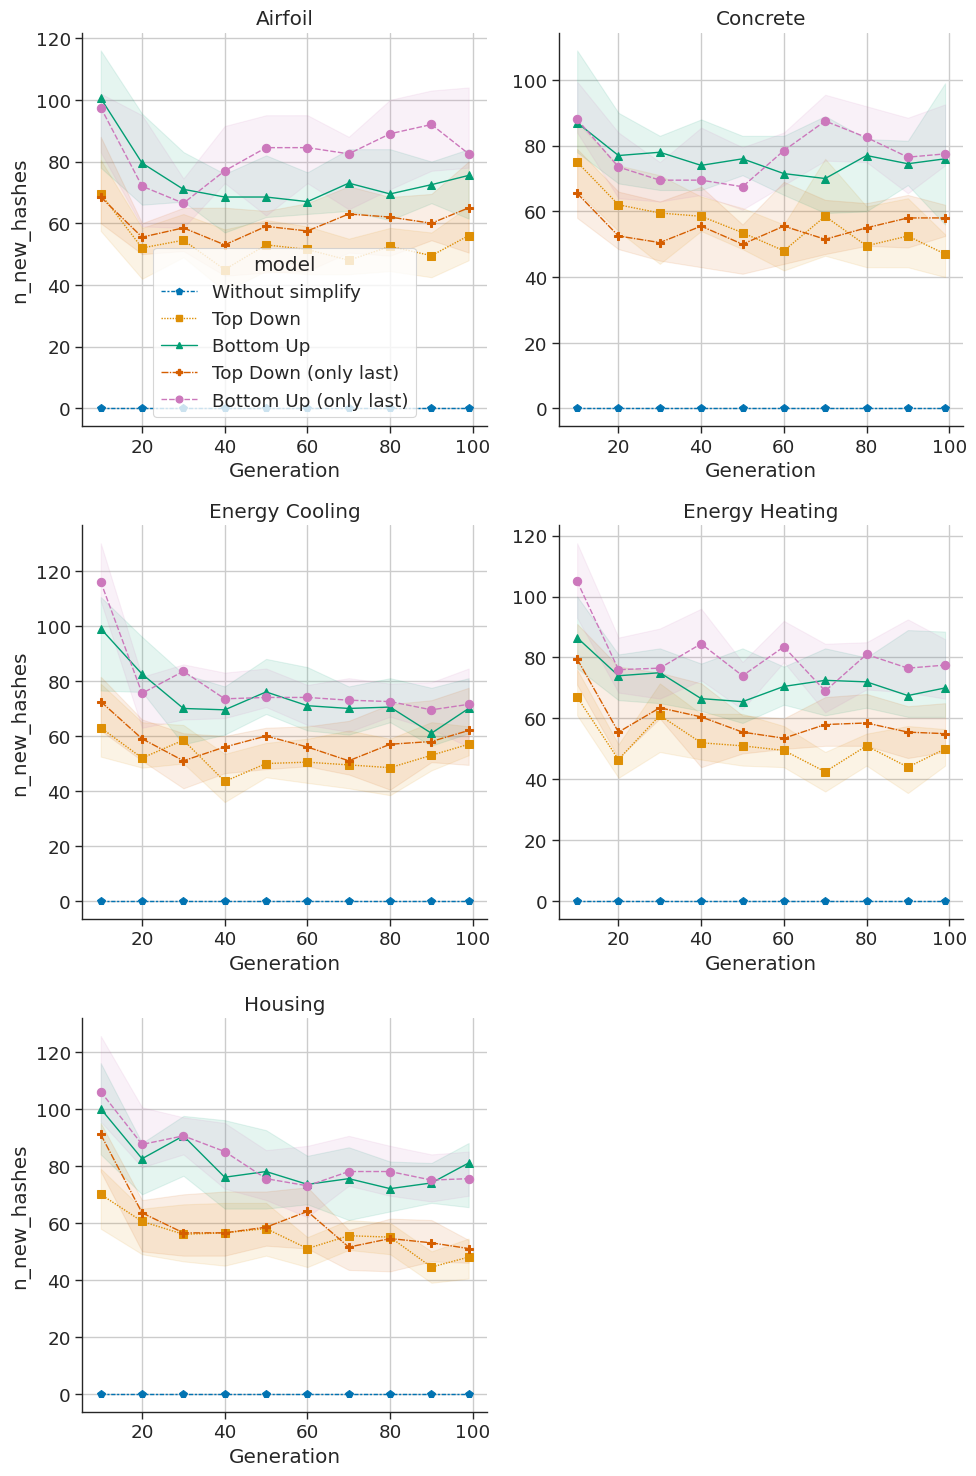

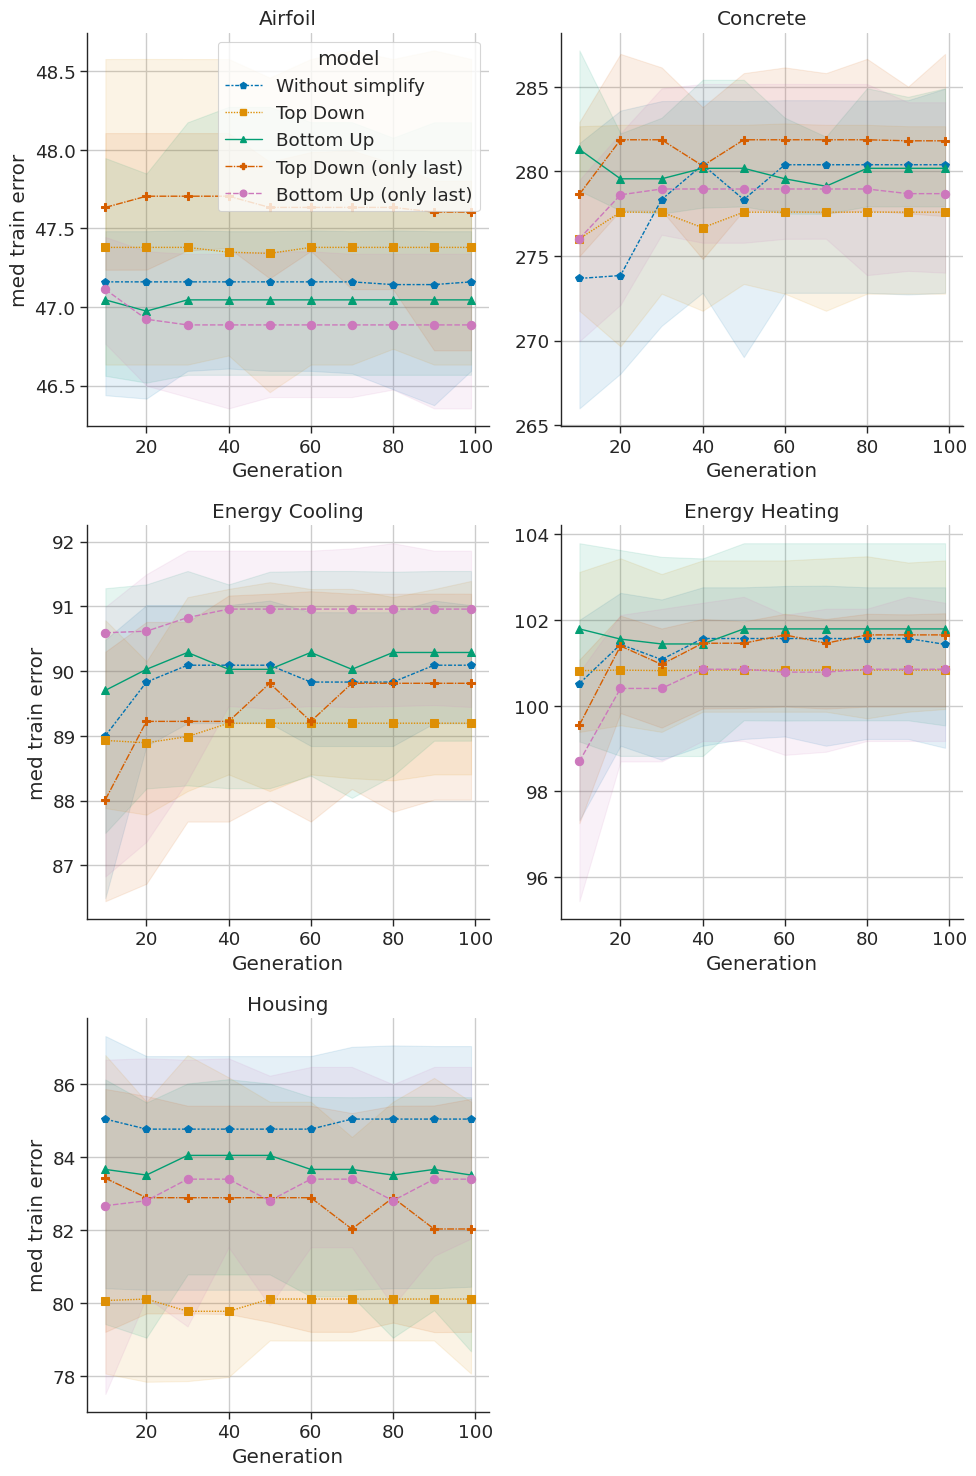

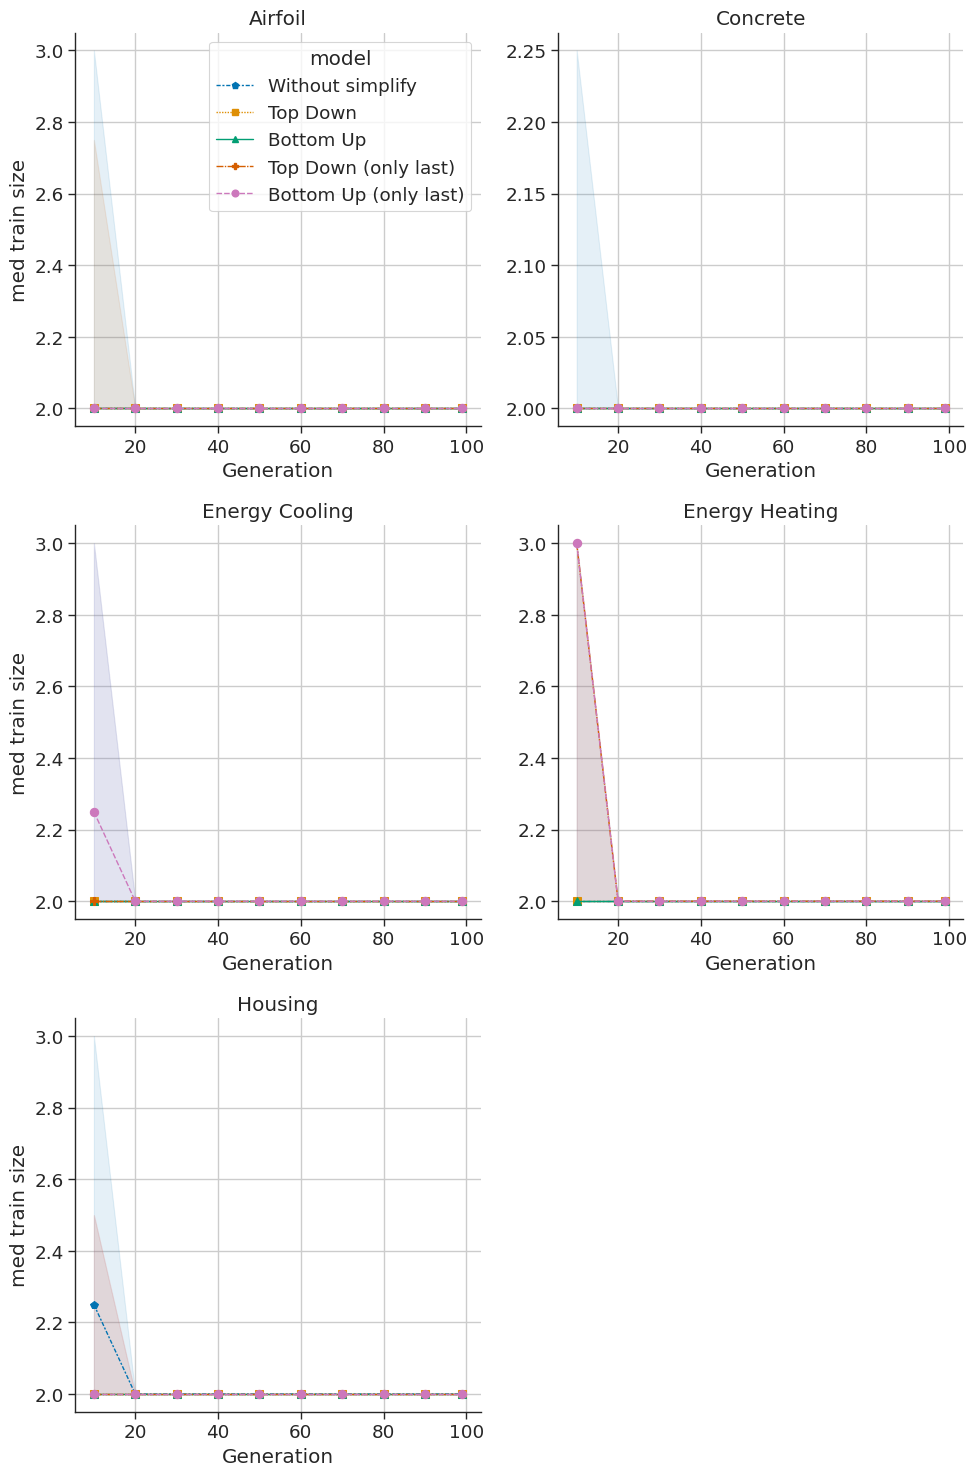

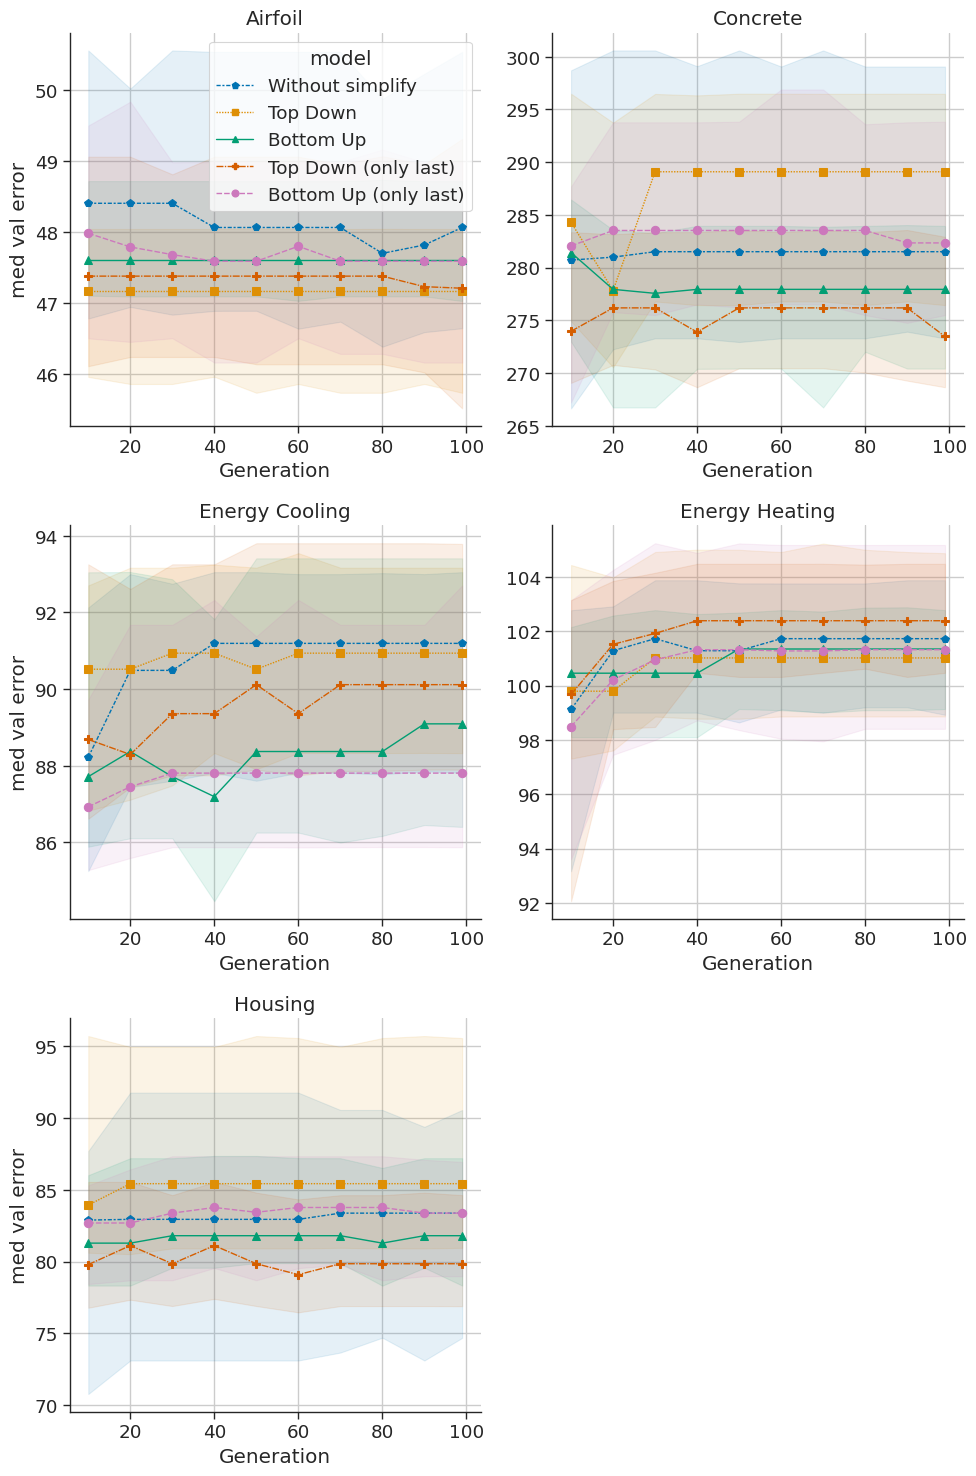

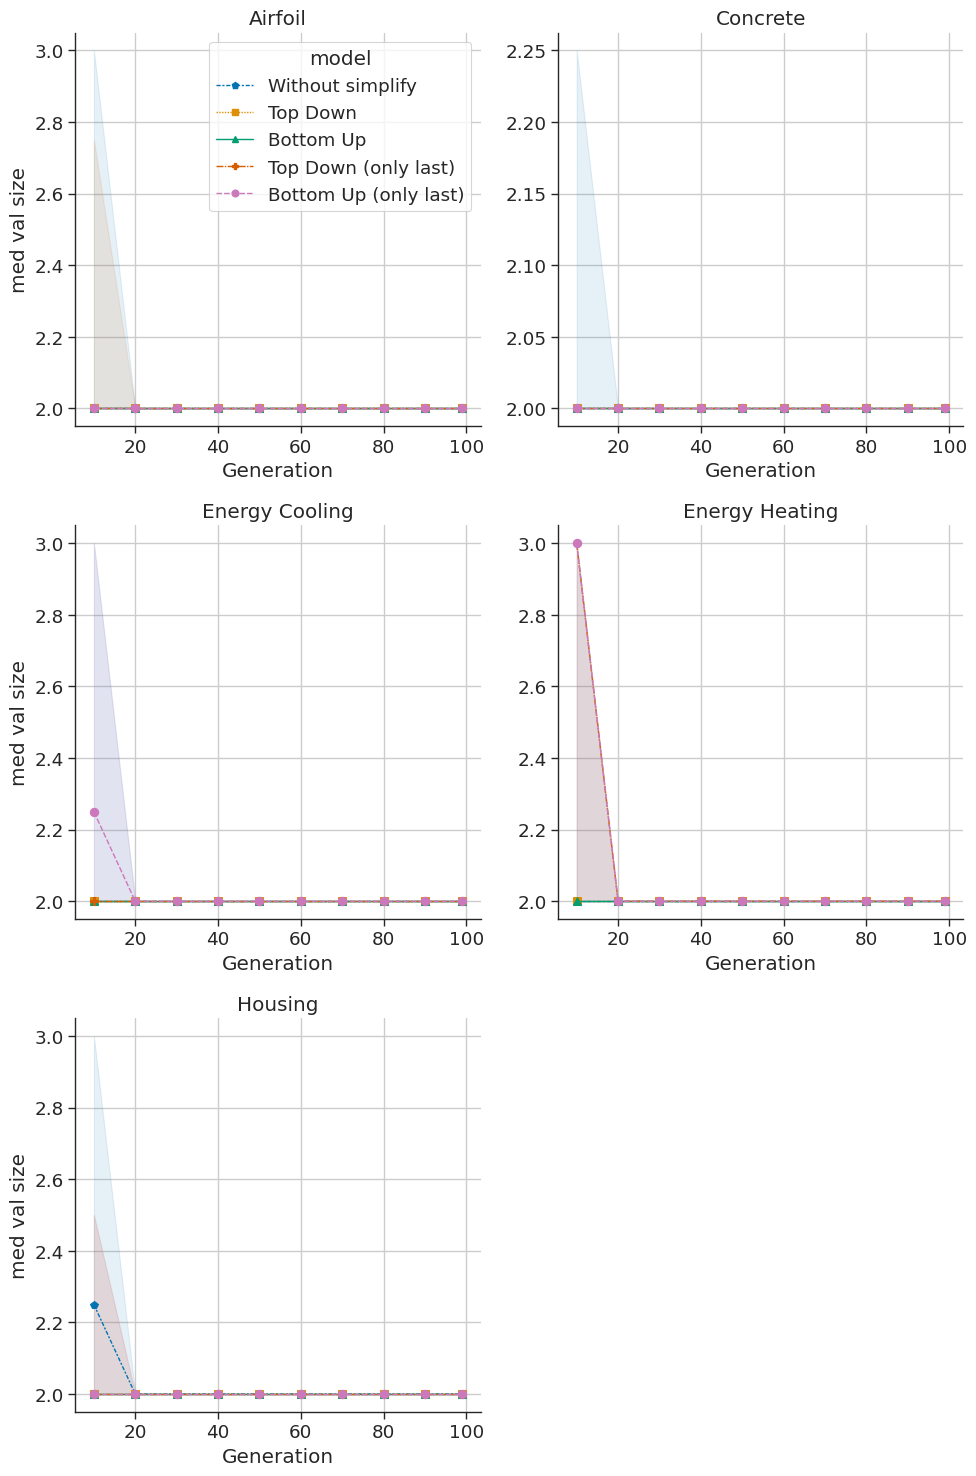

In [3]:
for col in [
    'best_size','min train error','min val error',
    'n_simplifications','n_new_hashes',
    'med train error','med train size','med val error','med val size',
]:
    
    # about errors: https://seaborn.pydata.org/tutorial/error_bars.html
    g = sns.relplot(
        data=all_data_df,
        x="gen", y=col, col="dataset", hue="model",
        style="model", col_wrap=col_wrap, markers=marker_choice, markeredgecolor=None, 
        kind="line", facet_kws={'sharey': False, 'sharex': False, 'legend_out':False}, #errorbar=None, #('ci', 50),
        hue_order = order, estimator=np.median, markersize=6,
        
        #err_style='bars', err_kws={'capsize':2.0, 'linewidth':0.75},
        err_style='band', err_kws={'alpha':0.1},
    )
    g.set_titles("{col_name}")

    for (ds, plot_ax) in g._axes_dict.items():
        plot_ax.grid(which='major', axis='both', linewidth=1)
        plot_ax.set_xlabel("Generation")

    if False: # use log scale
        # g.set(xscale="log")
        g.set(yscale="log")

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{col}.pdf")
    plt.savefig(f"../paper/figs/{col}.png")
    plt.show()